## Preprocess raw AHRF and save to CSV files

In [1]:
# Preprocess `AHRF 2016-2017 Technical Documentation.xlsx`
import re
import numpy as np
import pandas as pd
tb = pd.read_excel('AHRF 2016-2017 Technical Documentation.xlsx')
col_names = tb.iloc[181,:]

# Keep only valid rows
pattern = re.compile(" [0-9]*-[0-9]* ")
valid_row = [True if isinstance(tb.iloc[i, 1], str) and pattern.match(tb.iloc[i, 1]) is not None 
                  else False for i in range(tb.shape[0])]
tb = tb.loc[valid_row, :]

tb.columns = col_names

tb['FIELD'] = tb['FIELD'].apply(lambda x: x.strip())

# Convert str to int
tb['COL-COL'] = tb['COL-COL'].apply(lambda x: tuple(int(i) for i in x.split('-')))
tb['VARIABLE NAME'] = tb['VARIABLE NAME'].apply(lambda x:x.strip()) # remove leading/trailing white spaces
tb.to_csv('attributes_details.csv', index=False)

In [2]:
# Preprocess `ahrf2017.asc`
with open('ahrf2017.asc') as f:
    data = []
    j = 0
    for line in f:
        j += 1
        v = []
        for i in range(tb.shape[0]):
            cols = tb['COL-COL'].iloc[i] # Get field column range
            val = line[cols[0]-1:cols[1]]
            v.append(val)
        v = pd.Series(v, index=tb['FIELD'])
        data.append(v)
data = pd.DataFrame(data)
data.to_csv('data.csv', index=False)

## Class AHRF for accessing and searching AHRF data

In [23]:
import numpy as np
import pandas as pd
import plotly


class AHRF(object):
    """
    Read, access and visualize AHRF data

    Parameters
    ----------
    attributes : dataframe
        Return details of attributes such as year of data, variable name and characteristics
        
    """
    
    def __init__(self):
        self._var_details = pd.read_csv('attributes_details.csv')
        self._var_details.set_index('FIELD', inplace=True)
        self._var_details.drop('COL-COL', axis=1, inplace=True)
        self._var_details['YEAR OF DATA'] = self._var_details['YEAR OF DATA'].apply(str)
        self._data = pd.read_csv('data.csv')
        
    @property
    def attributes(self):
        return self._var_details
    
    def search(self, names=None, names_exact=None, years=None, is_detail=True):
        """
        Search and return data columns based on variable name
        
        Parameters
        ----------
        names : str or a list of strings
            example 1: 'Air Quality'
            example 2: ['Air Quality', 'State Name', 'County Name']
            A column will be selected if at least one item in `names` is a substring
            of the variable name
        names_exact : str or a list of strings or None
            Specify the exact variable name of the columns to be returned
        years : int or a list of int
            YEARS of data to be returned
        is_detail : True or False
            If True, column names will be FIELD + YEAR + VARIABLE NAME.
            If False, only FIELD will be given
        """
        if not names and not names_exact:
            return None       

        # Identy the columns to be returned
        cols = []
        if names is not None:
            if isinstance(names, str):
                names = [names]
            varnames = self._var_details['VARIABLE NAME']
            cols = [varnames.index[i] for i in range(len(varnames)) 
                        if any(map(lambda x: x in varnames.iloc[i], names))]
        if names_exact is not None:
            if isinstance(names_exact, str):
                names_exact = [names_exact]
            cols_exact = [varnames.index[i] for i in range(len(varnames)) 
                if any(map(lambda x: x == varnames.iloc[i], names_exact))]
            cols = list(set(cols+cols_exact)) # remove duplicates
        
        if years:
            # Select years, note the `YEAR OF DATA` column in `_var_details` may contain strings like '2006-10'
            # so we need to convert year to a list of str first
            if isinstance(years, (int, float)):
                years = [years]
            years = list(map(str, years))
            
            # If year is not specified (e.g. state name column) we return the column as well
            cols = [i for i in cols if not self._var_details.loc[i, 'YEAR OF DATA'].isnumeric()
                                       or any(map(lambda x:x in self._var_details.loc[i, 'YEAR OF DATA'], years))]
            
        if not cols:
            return None
        df = self._data[cols]

        # Rename the columns
        if is_detail:
            df.columns = [', '.join([i,
                                     str(self._var_details.loc[i, 'YEAR OF DATA']).strip(),
                                     self._var_details.loc[i, 'VARIABLE NAME']]) for i in df.columns]
        return df
    
    def us_heatmap(self, field, title=None, unit=None, fn2num=None):
        """
        Plot United States Choropleth Map
        
        Parameters
        ----------
        field : str
            The field to be plotted. e.g. 'F15266-14' for percentage of good air quality days
            Check self.attributes for the list of fields
        title : str
            Specify title of the plot
        unit : str
            Specify unit of the colorbar
        fn2num : a function
            The function for converting field value (string) to numeric. 
            If `None`, fn2num = lambda x: float(x)
        """
        if not any(self._data[field].apply(lambda x:x.isnumeric())):
            raise ValueError('Field `%s`: `%s` is not a numeric field!' % (field, self._var_details.loc[field, 
                                                                                                  'VARIABLE NAME']))
        if fn2num is None:
            fn2num = lambda x: float(x)

        if title is None:
            title = '%s in %s' % (self._var_details.loc[field, 'VARIABLE NAME'],
                                  self._var_details.loc[field, 'YEAR OF DATA'])

        dat = self._data.loc[:, ['F00008', 'F12424', 'F00010', field]]
        dat.columns = ['State', 'State Code', 'County', 'var']
        raw = dat.copy()
        dat['var'] = dat['var'].apply(fn2num)
        dat = dat.groupby(['State', 'State Code']).mean().reset_index()
     
        scl = [[0.0, 'rgb(242,240,247)'],[100.0, 'rgb(84,39,143)']]

        data = [ dict(
                type='choropleth',
                colorscale = scl,
                autocolorscale = True,
                locations = dat['State Code'],
                z = dat['var'],
                locationmode = 'USA-states',
                text = dat['State'],
                marker = dict(
                    line = dict (
                        color = 'rgb(255,255,255)',
                        width = 2
                    ) ),
                colorbar = dict(
                    title = unit)
                ) ]

        layout = dict(
                title = title,
                geo = dict(
                    scope='usa',
                    projection=dict( type='albers usa' ),
                    showlakes = True,
                    lakecolor = 'rgb(255, 255, 255)'),
                     )

        fig = dict( data=data, layout=layout )
        plotly.offline.iplot(fig, image='png')
        return raw

In [24]:
# List all attributes
import warnings
warnings.filterwarnings('ignore')
a = AHRF()
a.attributes

,YEAR OF DATA,VARIABLE NAME,CHARACTERISTICS,SOURCE,DATE ON
FIELD,,,,,
F00001,,Blank,,NaN,
F00002,,Header - FIPS St & Cty Code,,Derived From GSA,
F00003,,Entity of File,Equals 'AHRF ',NaN,
F00004,,Secondary Entity Of File,Mod FIPS St & Cty Code,Derived From GSA,
F00005,,Date of File,Equals '2017',NaN,07/17
F00006,,Date of Creation,Equals '17212',NaN,07/17
F00007,,File Length,Equals '31446',NaN,07/17
F00008,,State Name,,NaN,
F12424,,State Name Abbreviation,,U.S. Post Office,02/96


In [6]:
# Search for attributes
a.search(names='Air Quality', names_exact=['State Name',
                                           'County Name',
                                           'FIPS County Code'], years=[2014, 2016]).head()

,"F00012, , FIPS County Code","F15264-14, 2014, # Days Air Quality is Measured","F00008, , State Name","F00010, , County Name","F15264-16, 2016, # Days Air Quality is Measured","F15265-16, 2016, #Days Measured Air Quality Good","F15266-14, 2014, % Good Air Quality Days","F15265-14, 2014, #Days Measured Air Quality Good","F15266-16, 2016, % Good Air Quality Days"
0,1,.,Alabama,Autauga,.,.,.,.,.
1,3,284,Alabama,Baldwin,279,247,08768,249,08853
2,5,.,Alabama,Barbour,.,.,.,.,.
3,7,.,Alabama,Bibb,.,.,.,.,.
4,9,.,Alabama,Blount,.,.,.,.,.


## Data visualization example: Interactive heatmap of US air quality

In [25]:
# Plot Percent of good air quality days in 2016
# Note: Interactive plot doesn't seems to be rendered properly in github
plotly.offline.init_notebook_mode(connected=True)
fn = lambda x: float(x)*0.01 if x.isnumeric() else np.nan # Convert str to percentage value
dat = a.us_heatmap('F15266-16',
                   fn2num=fn,
                   unit = '%')
dat.head()

,State,State Code,County,var
0,Alabama,AL,Autauga,.
1,Alabama,AL,Baldwin,08853
2,Alabama,AL,Barbour,.
3,Alabama,AL,Bibb,.
4,Alabama,AL,Blount,.


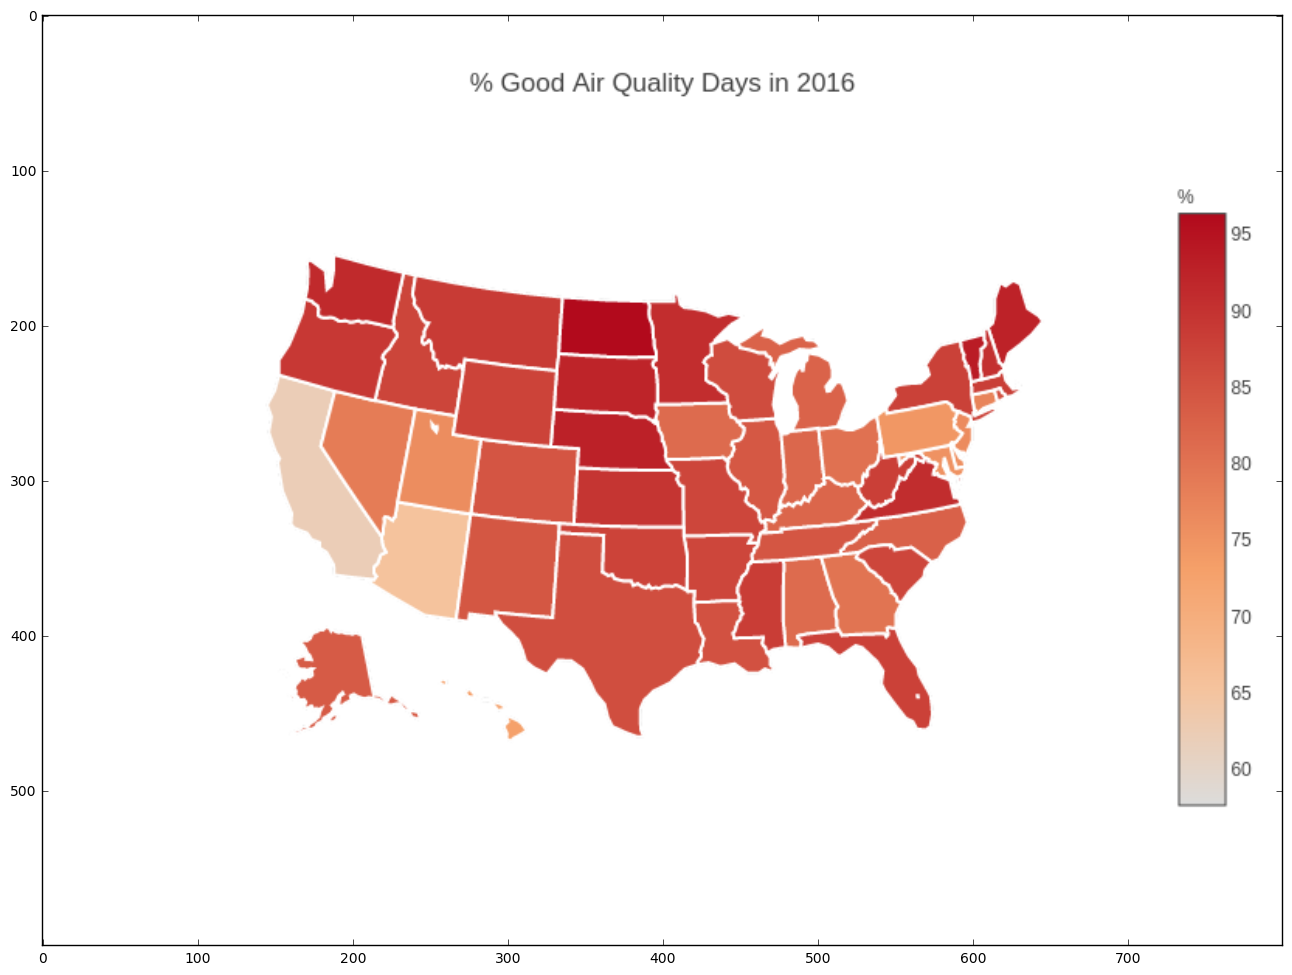

In [29]:
# Show the static plot

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pylab as pylab
import numpy as np

pylab.rcParams['figure.figsize'] = 16, 12
img=mpimg.imread('plot_image.png')
plt.imshow(img)
plt.show()